Using device: cuda


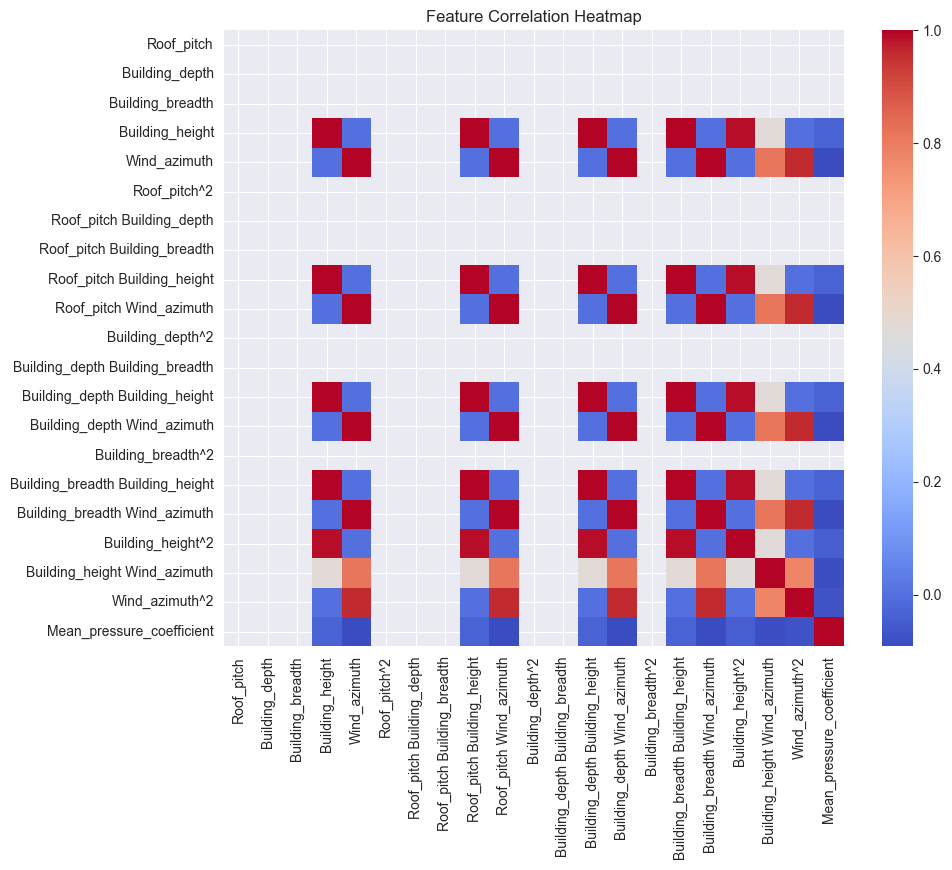

XGBoost - MAE: 0.0840, MAPE: 0.2528, MSE: 0.0115, R²: 0.0080


In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

# Check for GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# --- Data Loading Function ---
def load_and_preprocess_data(directory):
    """
    Load multiple .mat files, extract relevant features, and preprocess.
    """
    all_features = []
    all_targets = []

    for file in os.listdir(directory):
        if file.endswith(".mat"):
            data_path = os.path.join(directory, file)
            mat_data = loadmat(data_path)

            # Extract fields
            wind_pressure_coefficients = mat_data['Wind_pressure_coefficients']
            roof_pitch = mat_data['Roof_pitch'].flatten()
            building_depth = mat_data['Building_depth'].flatten()
            building_breadth = mat_data['Building_breadth'].flatten()
            building_height = mat_data['Building_height'].flatten()
            wind_azimuth = mat_data['Wind_azimuth'].flatten()

            mean_pressure_coefficients = wind_pressure_coefficients.mean(axis=1)

            # Ensure consistent feature lengths
            num_samples = len(mean_pressure_coefficients)
            features = pd.DataFrame({
                "Roof_pitch": np.tile(roof_pitch, num_samples // len(roof_pitch)),
                "Building_depth": np.tile(building_depth, num_samples // len(building_depth)),
                "Building_breadth": np.tile(building_breadth, num_samples // len(building_breadth)),
                "Building_height": np.tile(building_height, num_samples // len(building_height)),
                "Wind_azimuth": np.tile(wind_azimuth, num_samples // len(wind_azimuth)),
            })
            features["Mean_pressure_coefficient"] = mean_pressure_coefficients

            all_features.append(features.drop(columns=["Mean_pressure_coefficient"]))
            all_targets.append(features["Mean_pressure_coefficient"])

    # Combine all files
    combined_features = pd.concat(all_features, axis=0, ignore_index=True)
    combined_targets = pd.concat(all_targets, axis=0, ignore_index=True)
    return combined_features, combined_targets

# Load data
data_dir = "C:/Users/rrsuj/Downloads/capstone/data"  # Change to your directory path
features, targets = load_and_preprocess_data(data_dir)

# Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(features)
feature_names = poly.get_feature_names_out(features.columns)
poly_df = pd.DataFrame(poly_features, columns=feature_names)
poly_df["Mean_pressure_coefficient"] = targets

# --- Correlation Analysis ---
plt.figure(figsize=(10, 8))
corr_matrix = poly_df.corr()
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

# --- Train-Test Split ---
X = poly_df.drop(columns=["Mean_pressure_coefficient"])
y = poly_df["Mean_pressure_coefficient"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- XGBoost Model ---
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    max_depth=8,
    learning_rate=0.001,
    n_estimators=50,
    subsample=0.5,
    colsample_bytree=0.5,
    random_state=42
)
xgb_model.fit(X_train_scaled, y_train)

# XGBoost Evaluation
y_pred_xgb = xgb_model.predict(X_test_scaled)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost - MAE: {mae_xgb:.4f}, MAPE: {mape_xgb:.4f}, MSE: {mse_xgb:.4f}, R²: {r2_xgb:.4f}")

# --- Random Forest Model ---
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=8,
    random_state=42
)
rf_model.fit(X_train_scaled, y_train)

# Random Forest Evaluation
y_pred_rf = rf_model.predict(X_test_scaled)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - MAE: {mae_rf:.4f}, MAPE: {mape_rf:.4f}, MSE: {mse_rf:.4f}, R²: {r2_rf:.4f}")

# --- LightGBM Model ---
lgb_model = lgb.LGBMRegressor(
    objective='regression',
    max_depth=8,
    learning_rate=0.001,
    n_estimators=50,
    subsample=0.5,
    colsample_bytree=0.5,
    random_state=42
)
lgb_model.fit(X_train_scaled, y_train)

# LightGBM Evaluation
y_pred_lgb = lgb_model.predict(X_test_scaled)
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
mape_lgb = mean_absolute_percentage_error(y_test, y_pred_lgb)
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)

print(f"LightGBM - MAE: {mae_lgb:.4f}, MAPE: {mape_lgb:.4f}, MSE: {mse_lgb:.4f}, R²: {r2_lgb:.4f}")

# --- SVM Model ---
svm_model = SVR(kernel='rbf')
svm_model.fit(X_train_scaled, y_train)

# SVM Evaluation
y_pred_svm = svm_model.predict(X_test_scaled)
mae_svm = mean_absolute_error(y_test, y_pred_svm)
mape_svm = mean_absolute_percentage_error(y_test, y_pred_svm)
mse_svm = mean_squared_error(y_test, y_pred_svm)
r2_svm = r2_score(y_test, y_pred_svm)

print(f"SVM - MAE: {mae_svm:.4f}, MAPE: {mape_svm:.4f}, MSE: {mse_svm:.4f}, R²: {r2_svm:.4f}")

# --- Linear Regression Model ---
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Linear Regression Evaluation
y_pred_lr = lr_model.predict(X_test_scaled)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mape_lr = mean_absolute_percentage_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression - MAE: {mae_lr:.4f}, MAPE: {mape_lr:.4f}, MSE: {mse_lr:.4f}, R²: {r2_lr:.4f}")

# --- PIML Neural Network ---
class PressureDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(features, dtype=torch.float32).to(device)
        self.targets = torch.tensor(targets, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

train_dataset = PressureDataset(X_train_scaled, y_train.values)
test_dataset = PressureDataset(X_test_scaled, y_test.values)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class RegressionModel(nn.Module):
    def __init__(self, input_size):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(0.3)
        self.fc4 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.dropout(torch.relu(self.fc3(x)))
        x = self.fc4(x)
        return x

model = RegressionModel(input_size=X_train_scaled.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

# Train the model
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for features, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for features, targets in test_loader:
            outputs = model(features)
            val_loss += criterion(outputs.squeeze(), targets).item()

    val_losses.append(val_loss / len(test_loader))
    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

# Plot Training vs Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("PIML Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Evaluate PIML model
y_pred_p = []
y_true_p = []
model.eval()
with torch.no_grad():
    for features, targets in test_loader:
        outputs = model(features)
        y_pred_p.append(outputs.squeeze().cpu().numpy())
        y_true_p.append(targets.cpu().numpy())

y_pred_p = np.concatenate(y_pred_p)
y_true_p = np.concatenate(y_true_p)

mae_piml = mean_absolute_error(y_true_p, y_pred_p)
mape_piml = mean_absolute_percentage_error(y_true_p, y_pred_p)
mse_piml = mean_squared_error(y_true_p, y_pred_p)
r2_piml = r2_score(y_true_p, y_pred_p)

print(f"PIML - MAE: {mae_piml:.4f}, MAPE: {mape_piml:.4f}, MSE: {mse_piml:.4f}, R²: {r2_piml:.4f}")

# Comparison Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5, color='red', edgecolor='k', label='XGBoost')
plt.scatter(y_true_p, y_pred_p, alpha=0.5, color='blue', edgecolor='k', label='PIML')
plt.xlabel("True Mean Pressure Coefficients")
plt.ylabel("Predicted Mean Pressure Coefficients")
plt.title("True vs Predicted Mean Pressure Coefficients")
plt.legend()
plt.grid(True)
plt.show()

